In [16]:
import helpers.input_processor as ip

data_dir = 'data/raw_training/training_data'
data_frame = ip.ingest_data(data_dir)


Cache already exists. Skipping cache creation


Reading from .txt files in data/raw_training/training_data: 100%|██████████| 942/942 [00:00<00:00, 13827.18it/s]


In [17]:
import os
import numpy as np
spectro_cache = "data/__spectro_cache__"

training_data = []
training_labels = []

# loop over each row in the dataframe
for i in range(len(data_frame)):

    for files in data_frame[i]["audio_file"].to_list():
        for file in files:
            # check if the audio_file has a murmur location
            contains_murmur = False
            for murmur_locations in data_frame[i]["murmur_locations"].to_list():
                for location in murmur_locations:
                    # check if the murmur location is in the string of audio_file
                    if location in file:
                        # if so, add the spectrogram to the training data
                        spectro = np.load(os.path.join(spectro_cache, str.replace(file, ".wav", ".npy")))
                        training_data.append(spectro)
                        # we mark labels as 1 if the file is a murmur
                        training_labels.append(1)
                        contains_murmur = True
            if not contains_murmur:
                # if the file is not a murmur, add the spectrogram to the training data
                spectro = np.load(os.path.join(spectro_cache, str.replace(file, ".wav", ".npy")))
                training_data.append(spectro)
                # we mark labels as 0 if the file is not a murmur
                training_labels.append(0)
                    



Spectrograms Processed: 100%|██████████| 3163/3163 [01:14<00:00, 42.51it/s] 


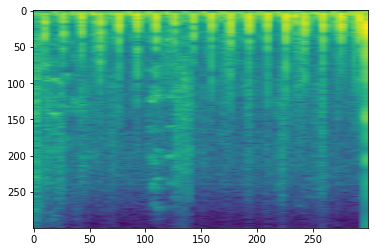

In [18]:
import tensorflow as tf
import skimage.transform as st
import numpy as np
import tqdm
import matplotlib.pyplot as plt

progress_bar = tqdm.tqdm(total=len(training_data))
progress_bar.set_description('Spectrograms Processed')
progress_bar.n = 0
progress_bar.refresh()

# loop through the specrograms and resize them to 300x300
for i in range(len(training_data)):
    training_data[i] = st.resize(training_data[i], (300, 300))
    progress_bar.update(1)


plt.imshow(training_data[0], aspect='auto')


0
(300, 300)


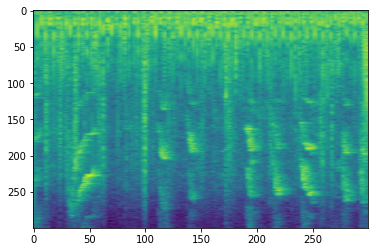

In [19]:
import matplotlib.pyplot as plt
import random

random_index = random.randint(0, len(training_data))

# display a random spectrogram
plt.imshow(training_data[random_index], aspect='auto')
print(training_labels[random_index])
print(training_data[random_index].shape)

In [20]:
training_data = np.array(training_data, dtype=np.float32)
training_labels = np.array(training_labels, dtype=np.float32)

print(training_data.shape)

(3163, 300, 300)


In [21]:
training_data = training_data.reshape([-1, 300, 300, 1])

In [22]:
print(training_data.shape)

(3163, 300, 300, 1)


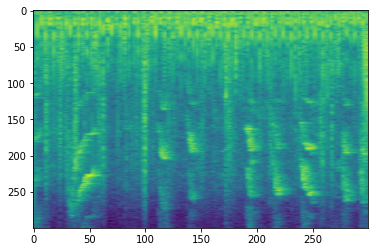

In [23]:
# display a random spectrogram
plt.imshow(training_data[random_index], aspect='auto')

In [24]:
from imgaug import augmenters as iaa

seq = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0.0, 1.0)),
    #iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        translate_percent={"x": (-0.05, 0.05), "y": (0, 0)},
    ),
    iaa.LinearContrast((0.8, 1.2))
], random_order=True)

training_data_augmented = training_data.copy()
training_labels_augmented = training_labels.copy()

images_augmented = seq(images=training_data)
    



In [25]:
print(images_augmented.shape)

(3163, 300, 300, 1)


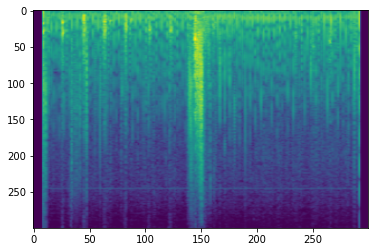

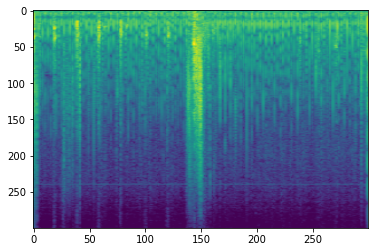

In [26]:
# show random augmented spectrograms
random_index = random.randint(0, len(training_data))

# show image
plt.imshow(images_augmented[random_index], aspect='auto')
plt.show()
plt.imshow(training_data[random_index], aspect='auto')
plt.show()

In [27]:
long_training_data = np.append(training_data, images_augmented, axis=0)
long_training_labels = np.append(training_labels, training_labels, axis=0)

In [28]:
print(long_training_data.shape)
print(long_training_labels.shape)

(6326, 300, 300, 1)
(6326,)


In [29]:
# stop jupyter notebook from exicuting the rest of the code
%stop

UsageError: Line magic function `%stop` not found.


In [30]:
%load_ext tensorboard
import keras as ks
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, Input, MaxPooling2D



# create the model
model = Sequential()

# add the input that can take in any image size

model.add(Conv2D(32, (3, 3), input_shape=(300, 300, 1), strides=(1, 1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same') )
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

Dropout(0.25)

model.add(Dense(1024, activation='relu'))

model.add(Dense(512, activation='relu'))

model.add(Dense(256, activation='relu'))

model.add(Dense(128, activation='relu'))

model.add(Dense(64, activation='relu'))

model.add(Dense(1, activation='sigmoid'))


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


2022-06-27 15:13:43.821948: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 168.82GiB (rounded to 181269430272)requested by op RandomUniform
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-06-27 15:13:43.822029: I tensorflow/core/common_runtime/bfc_allocator.cc:1027] BFCAllocator dump for GPU_0_bfc
2022-06-27 15:13:43.822059: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (256): 	Total Chunks: 16, Chunks in use: 16. 4.0KiB allocated for chunks. 4.0KiB in use in bin. 820B client-requested in use in bin.
2022-06-27 15:13:43.822100: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2022-06-27 15:13:43.822119: I

ResourceExhaustedError: OOM when allocating tensor with shape[22127616,2048] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]

In [ ]:
from keras.optimizers import Adam
import datetime

# set the optimizer
optimizer = Adam(lr=0.001)

# binary cross entropy loss function
model.compile(loss='binary_crossentropy' , optimizer=optimizer, metrics=['accuracy'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(long_training_data, long_training_labels, epochs=50, batch_size=300, validation_split=0.25 , shuffle=True)



Epoch 1/50
16/16 [==============================] - 11s 549ms/step - loss: 0.4847 - accuracy: 0.8364 - val_loss: 0.4229 - val_accuracy: 0.8597
Epoch 2/50
16/16 [==============================] - 6s 386ms/step - loss: 0.4385 - accuracy: 0.8364 - val_loss: 0.3935 - val_accuracy: 0.8597
Epoch 3/50
16/16 [==============================] - 6s 386ms/step - loss: 0.4281 - accuracy: 0.8364 - val_loss: 0.3916 - val_accuracy: 0.8597
Epoch 4/50
16/16 [==============================] - 6s 391ms/step - loss: 0.4279 - accuracy: 0.8364 - val_loss: 0.4200 - val_accuracy: 0.8597
Epoch 5/50
16/16 [==============================] - 7s 418ms/step - loss: 0.4331 - accuracy: 0.8364 - val_loss: 0.4159 - val_accuracy: 0.8597
Epoch 6/50
16/16 [==============================] - 7s 429ms/step - loss: 0.4210 - accuracy: 0.8364 - val_loss: 0.3864 - val_accuracy: 0.8597
Epoch 7/50
16/16 [==============================] - 7s 437ms/step - loss: 0.4134 - accuracy: 0.8417 - val_loss: 0.3734 - val_accuracy: 0.8660
Epoch

In [ ]:
# graph loss over time 
print(history.history.keys())
# plot validation loss
plt.plot(history.history['val_loss'])

# plot training loss
plt.plot(history.history['loss'])
plt.show()

plt.plot(history.history['accuracy'])

plt.plot(history.history['val_accuracy'])
plt.show()

NameError: name 'history' is not defined

In [ ]:
# choose a random spectrogram and predict the murmur
random_index = random.randint(0, len(training_data))
print(model.predict(training_data[random_index].reshape([1, 300, 300, 1])))

print(training_labels[random_index])

1/1 [==============================] - 0s 22ms/step
[[9.5067706e-05]]
0.0


In [ ]:
success = 0
failure = 0
i = 0

validation_bar = tqdm.tqdm(total=len(training_data))
validation_bar.reset(total=len(training_data))

validation_bar.set_description('Checking Validation Data')
for spectro in training_data:
    prediction = model.predict(spectro.reshape([1, 300, 300, 1]), verbose=0)
    if prediction[0][0] > 0.5 and training_labels[i] == 1:
        success += 1
        #print("Success")
    elif prediction[0][0] < 0.5 and training_labels[i] == 0:
        success += 1
        #print("Success")
    else:
        failure += 1
        print("Failure")
    i += 1
    validation_bar.update(1)
    validation_bar.refresh()

print("Success: " + str(success))
print("Failure: " + str(failure))

print("Success Rate: " + str(success/(success+failure)))
    

Checking Validation Data:   0%|          | 8/3163 [00:00<02:50, 18.53it/s]

Failure


Checking Validation Data:   2%|▏         | 77/3163 [00:04<02:48, 18.31it/s]

Failure


Checking Validation Data:  14%|█▎        | 434/3163 [00:23<02:27, 18.55it/s]

Failure


Checking Validation Data:  17%|█▋        | 531/3163 [00:28<02:21, 18.59it/s]

Failure


Checking Validation Data:  19%|█▊        | 586/3163 [00:31<02:18, 18.63it/s]

Failure


Checking Validation Data:  23%|██▎       | 727/3163 [00:39<02:14, 18.15it/s]

Failure


Checking Validation Data:  32%|███▏      | 1011/3163 [00:55<01:57, 18.27it/s]

Failure


Checking Validation Data:  33%|███▎      | 1048/3163 [00:57<01:57, 18.06it/s]

Failure


Checking Validation Data:  37%|███▋      | 1173/3163 [01:03<01:47, 18.58it/s]

Failure


Checking Validation Data:  38%|███▊      | 1211/3163 [01:05<01:44, 18.72it/s]

Failure


Checking Validation Data:  43%|████▎     | 1353/3163 [01:13<01:39, 18.22it/s]

Failure


Checking Validation Data:  46%|████▋     | 1465/3163 [01:19<01:31, 18.61it/s]

Failure


Checking Validation Data:  48%|████▊     | 1523/3163 [01:23<01:30, 18.15it/s]

Failure


Checking Validation Data:  50%|█████     | 1597/3163 [01:27<01:25, 18.25it/s]

Failure


Checking Validation Data:  52%|█████▏    | 1658/3163 [01:30<01:20, 18.59it/s]

Failure


Checking Validation Data:  56%|█████▌    | 1756/3163 [01:35<01:15, 18.57it/s]

Failure


Checking Validation Data:  56%|█████▌    | 1765/3163 [01:36<01:15, 18.49it/s]

Failure


Checking Validation Data:  58%|█████▊    | 1839/3163 [01:40<01:11, 18.55it/s]

Failure


Checking Validation Data:  66%|██████▌   | 2085/3163 [01:53<00:58, 18.30it/s]

Failure


Checking Validation Data:  70%|██████▉   | 2210/3163 [02:00<00:51, 18.64it/s]

Failure


Checking Validation Data:  74%|███████▍  | 2347/3163 [02:08<00:45, 18.06it/s]

Failure


Checking Validation Data:  76%|███████▌  | 2390/3163 [02:10<00:42, 18.29it/s]

Failure


Checking Validation Data:  77%|███████▋  | 2445/3163 [02:13<00:38, 18.42it/s]

Failure


Checking Validation Data:  78%|███████▊  | 2481/3163 [02:15<00:36, 18.57it/s]

Failure
Failure
Failure


Checking Validation Data:  79%|███████▉  | 2502/3163 [02:16<00:36, 18.31it/s]

Failure


Checking Validation Data:  79%|███████▉  | 2510/3163 [02:16<00:35, 18.65it/s]

Failure


Checking Validation Data:  80%|███████▉  | 2526/3163 [02:17<00:34, 18.21it/s]

Failure
Failure
Failure


Checking Validation Data:  80%|████████  | 2531/3163 [02:17<00:34, 18.47it/s]

Failure
Failure


Checking Validation Data:  81%|████████  | 2549/3163 [02:19<00:34, 17.89it/s]

Failure


Checking Validation Data:  81%|████████  | 2556/3163 [02:19<00:32, 18.63it/s]

Failure
Failure


Checking Validation Data:  81%|████████  | 2564/3163 [02:20<00:32, 18.29it/s]

Failure


Checking Validation Data:  81%|████████▏ | 2570/3163 [02:20<00:32, 18.49it/s]

Failure
Failure
Failure


Checking Validation Data:  82%|████████▏ | 2579/3163 [02:20<00:31, 18.68it/s]

Failure
Failure
Failure


Checking Validation Data:  82%|████████▏ | 2584/3163 [02:21<00:31, 18.52it/s]

Failure
Failure


Checking Validation Data:  82%|████████▏ | 2598/3163 [02:21<00:30, 18.74it/s]

Failure


Checking Validation Data:  83%|████████▎ | 2610/3163 [02:22<00:30, 18.28it/s]

Failure
Failure
Failure
Failure


Checking Validation Data:  83%|████████▎ | 2614/3163 [02:22<00:30, 17.89it/s]

Failure
Failure
Failure
Failure


Checking Validation Data:  83%|████████▎ | 2626/3163 [02:23<00:28, 18.55it/s]

Failure
Failure
Failure
Failure


Checking Validation Data:  84%|████████▎ | 2646/3163 [02:24<00:27, 18.70it/s]

Failure


Checking Validation Data:  84%|████████▍ | 2650/3163 [02:24<00:27, 18.82it/s]

Failure


Checking Validation Data:  84%|████████▍ | 2665/3163 [02:25<00:26, 18.61it/s]

Failure


Checking Validation Data:  84%|████████▍ | 2670/3163 [02:25<00:26, 18.63it/s]

Failure
Failure
Failure
Failure


Checking Validation Data:  85%|████████▍ | 2674/3163 [02:25<00:26, 18.30it/s]

Failure


Checking Validation Data:  85%|████████▌ | 2699/3163 [02:27<00:25, 18.10it/s]

Failure
Failure


Checking Validation Data:  86%|████████▌ | 2711/3163 [02:27<00:24, 18.53it/s]

Failure
Failure


Checking Validation Data:  86%|████████▋ | 2732/3163 [02:29<00:22, 18.92it/s]

Failure
Failure
Failure


Checking Validation Data:  87%|████████▋ | 2736/3163 [02:29<00:22, 18.59it/s]

Failure
Failure


Checking Validation Data:  87%|████████▋ | 2744/3163 [02:29<00:23, 18.07it/s]

Failure


Checking Validation Data:  87%|████████▋ | 2762/3163 [02:30<00:21, 18.86it/s]

Failure


Checking Validation Data:  88%|████████▊ | 2774/3163 [02:31<00:20, 18.55it/s]

Failure


Checking Validation Data:  88%|████████▊ | 2780/3163 [02:31<00:20, 18.74it/s]

Failure


Checking Validation Data:  88%|████████▊ | 2789/3163 [02:32<00:19, 18.75it/s]

Failure
Failure


Checking Validation Data:  89%|████████▊ | 2803/3163 [02:32<00:19, 18.90it/s]

Failure


Checking Validation Data:  89%|████████▊ | 2807/3163 [02:33<00:19, 18.66it/s]

Failure
Failure


Checking Validation Data:  89%|████████▉ | 2814/3163 [02:33<00:18, 18.83it/s]

Failure


Checking Validation Data:  89%|████████▉ | 2822/3163 [02:33<00:18, 18.58it/s]

Failure


Checking Validation Data:  89%|████████▉ | 2828/3163 [02:34<00:18, 18.46it/s]

Failure
Failure


Checking Validation Data:  90%|█████████ | 2859/3163 [02:35<00:16, 18.34it/s]

Failure
Failure


Checking Validation Data:  91%|█████████ | 2868/3163 [02:36<00:16, 18.03it/s]

Failure


Checking Validation Data:  91%|█████████ | 2874/3163 [02:36<00:15, 18.29it/s]

Failure
Failure


Checking Validation Data:  91%|█████████ | 2881/3163 [02:37<00:15, 18.05it/s]

Failure
Failure
Failure


Checking Validation Data:  92%|█████████▏| 2895/3163 [02:37<00:14, 18.66it/s]

Failure


Checking Validation Data:  92%|█████████▏| 2906/3163 [02:38<00:13, 18.40it/s]

Failure


Checking Validation Data:  92%|█████████▏| 2910/3163 [02:38<00:13, 18.32it/s]

Failure
Failure
Failure


Checking Validation Data:  92%|█████████▏| 2923/3163 [02:39<00:13, 18.42it/s]

Failure


Checking Validation Data:  93%|█████████▎| 2935/3163 [02:40<00:12, 18.88it/s]

Failure


Checking Validation Data:  94%|█████████▎| 2959/3163 [02:41<00:11, 17.83it/s]

Failure


Checking Validation Data:  94%|█████████▍| 2967/3163 [02:41<00:10, 18.29it/s]

Failure
Failure


Checking Validation Data:  94%|█████████▍| 2984/3163 [02:42<00:09, 18.55it/s]

Failure
Failure


Checking Validation Data:  95%|█████████▍| 2994/3163 [02:43<00:08, 18.90it/s]

Failure


Checking Validation Data:  95%|█████████▍| 2999/3163 [02:43<00:08, 18.30it/s]

Failure


Checking Validation Data:  95%|█████████▌| 3005/3163 [02:43<00:08, 18.38it/s]

Failure


Checking Validation Data:  95%|█████████▌| 3011/3163 [02:44<00:08, 18.55it/s]

Failure


Checking Validation Data:  95%|█████████▌| 3016/3163 [02:44<00:07, 18.82it/s]

Failure


Checking Validation Data:  97%|█████████▋| 3058/3163 [02:46<00:05, 17.90it/s]

Failure


Checking Validation Data:  97%|█████████▋| 3063/3163 [02:47<00:05, 18.07it/s]

Failure


Checking Validation Data:  97%|█████████▋| 3072/3163 [02:47<00:05, 17.90it/s]

Failure
Failure
Failure


Checking Validation Data:  97%|█████████▋| 3077/3163 [02:47<00:04, 18.55it/s]

Failure


Checking Validation Data:  98%|█████████▊| 3096/3163 [02:48<00:03, 17.90it/s]

Failure


Checking Validation Data:  99%|█████████▊| 3119/3163 [02:50<00:02, 18.55it/s]

Failure


Checking Validation Data:  99%|█████████▉| 3124/3163 [02:50<00:02, 18.75it/s]

Failure
Failure


Checking Validation Data:  99%|█████████▉| 3141/3163 [02:51<00:01, 18.43it/s]

Failure


Checking Validation Data: 100%|█████████▉| 3149/3163 [02:51<00:00, 18.59it/s]

Failure
Failure


Checking Validation Data: 100%|█████████▉| 3153/3163 [02:51<00:00, 18.39it/s]

Failure


Checking Validation Data: 100%|█████████▉| 3159/3163 [02:52<00:00, 18.21it/s]

Failure
Failure
Failure


Checking Validation Data: 100%|██████████| 3163/3163 [02:52<00:00, 18.16it/s]

Success: 3033
Failure: 130
Success Rate: 0.958899778691116


Checking Validation Data: 100%|██████████| 3163/3163 [03:12<00:00, 18.16it/s]